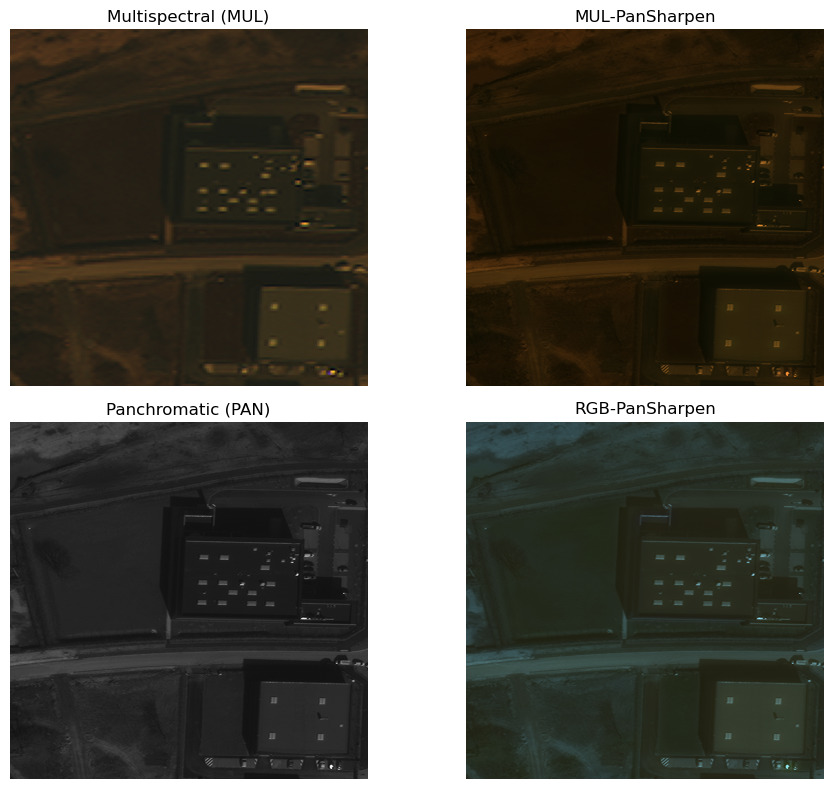

In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from rasterio.plot import reshape_as_image

def normalize(img):
    """Normalize image to 0–1 range for display."""
    img = img.astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    return img

# Base path and image ID
base_path = "/home/paster/LMY/AOI_3_Paris_Train"
image_id = "AOI_3_Paris_img27.tif"

# Folder and display names
folders = [
    ("MUL", "Multispectral (MUL)"),
    ("MUL-PanSharpen", "MUL-PanSharpen"),
    ("PAN", "Panchromatic (PAN)"),
    ("RGB-PanSharpen", "RGB-PanSharpen"),
]

# Prepare plot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for ax, (folder, title) in zip(axs.flat, folders):
    image_path = f"{base_path}/{folder}/{folder}_{image_id}"
    
    try:
        with rasterio.open(image_path) as src:
            img = src.read()

            if img.shape[0] >= 3:
                # Reorder to RGB and normalize
                img_rgb = reshape_as_image(img[:3][[2, 1, 0]])
                img_disp = normalize(img_rgb)
            else:
                img_gray = img[0]
                img_disp = normalize(img_gray)

        ax.imshow(img_disp, cmap='gray' if img_disp.ndim == 2 else None)
        ax.set_title(title)
        ax.axis("off")

    except Exception as e:
        ax.set_title(f"{title}\n[Error loading]")
        ax.axis("off")
        print(f"Could not load {image_path}: {e}")

plt.tight_layout()
plt.show()


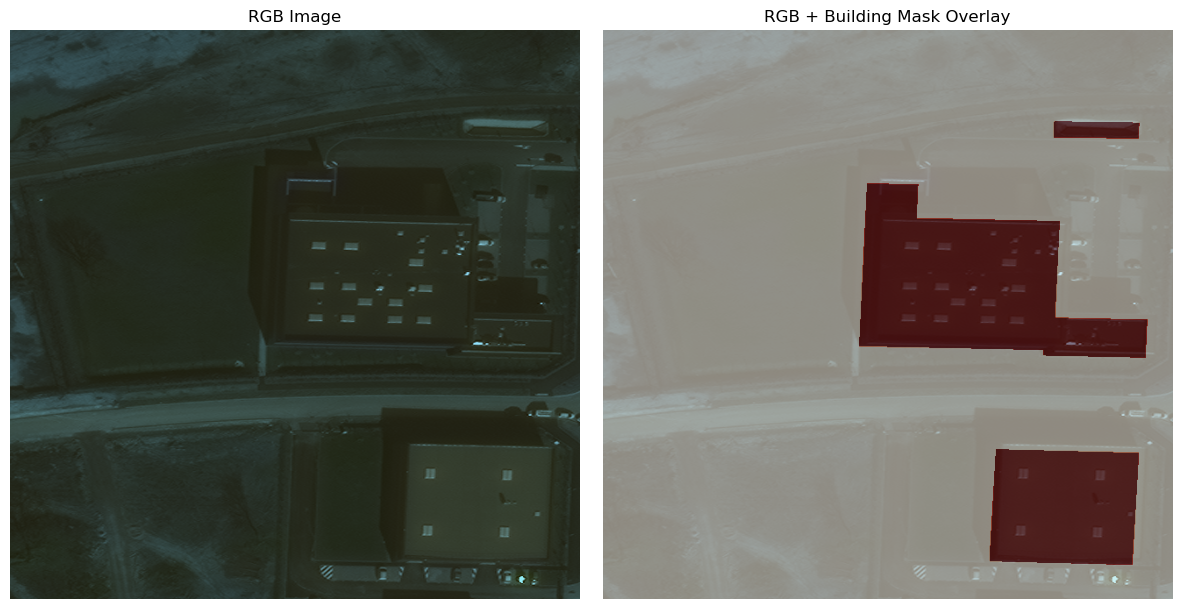

In [6]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import shape
from rasterio.plot import reshape_as_image
from rasterio.features import rasterize

def normalize(img):
    img = img.astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    return img

# --- Paths ---
base_path = "/home/paster/LMY/AOI_3_Paris_Train"
image_file = f"{base_path}/RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img27.tif"
geojson_file = f"{base_path}/geojson/buildings/buildings_AOI_3_Paris_img27.geojson"

# --- Load image ---
with rasterio.open(image_file) as src:
    img = src.read([3, 2, 1])  # Bands reordered to RGB
    img = reshape_as_image(img)
    img = normalize(img)
    transform = src.transform
    image_shape = src.shape

# --- Load GeoJSON and transform to image CRS ---
gdf = gpd.read_file(geojson_file)
gdf = gdf.to_crs(crs=src.crs)  # match image CRS

# --- Rasterize polygons into mask ---
shapes = [(geom, 1) for geom in gdf.geometry]
mask = rasterize(shapes, out_shape=image_shape, transform=transform, fill=0)

# --- Plot RGB and mask overlay ---
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Image only
axs[0].imshow(img)
axs[0].set_title("RGB Image")
axs[0].axis("off")

# Overlay
axs[1].imshow(img)
axs[1].imshow(mask, cmap="Reds", alpha=0.5)
axs[1].set_title("RGB + Building Mask Overlay")
axs[1].axis("off")

plt.tight_layout()
plt.show()


## Count .tif files in RGB-PanSharpen/

## Count .geojson files in geojson/

In [7]:
import os

# Define paths
rgb_dir = "/home/paster/LMY/AOI_3_Paris_Train/RGB-PanSharpen"
geojson_dir = "/home/paster/LMY/AOI_3_Paris_Train/geojson"

# Count .tif files in RGB-PanSharpen
tif_count = len([f for f in os.listdir(rgb_dir) if f.endswith(".tif")])

# Count .geojson files in geojson folder (including subfolders like 'buildings/')
geojson_count = 0
for root, dirs, files in os.walk(geojson_dir):
    geojson_count += len([f for f in files if f.endswith(".geojson")])

# Print results
print(f"TIFF files in RGB-PanSharpen: {tif_count}")
print(f"GeoJSON files in geojson/: {geojson_count}")


TIFF files in RGB-PanSharpen: 1148
GeoJSON files in geojson/: 1148


## types of files are inside rgb_dir  and geojson_dir 

In [8]:
import os
from collections import Counter

def list_extensions(directory):
    ext_counter = Counter()
    for root, _, files in os.walk(directory):
        for f in files:
            ext = os.path.splitext(f)[1].lower()  # get file extension
            ext_counter[ext] += 1
    return ext_counter

# Define paths
rgb_dir = "/home/paster/LMY/AOI_3_Paris_Train/RGB-PanSharpen"
geojson_dir = "/home/paster/LMY/AOI_3_Paris_Train/geojson"

# Get extension counts
rgb_exts = list_extensions(rgb_dir)
geojson_exts = list_extensions(geojson_dir)

# Print results
print("File types in RGB-PanSharpen:")
for ext, count in rgb_exts.items():
    print(f"  {ext or '[no extension]'}: {count}")

print("\nFile types in geojson/:")
for ext, count in geojson_exts.items():
    print(f"  {ext or '[no extension]'}: {count}")


File types in RGB-PanSharpen:
  .tif: 1148

File types in geojson/:
  .geojson: 1148


## distribution of tiff files height and width

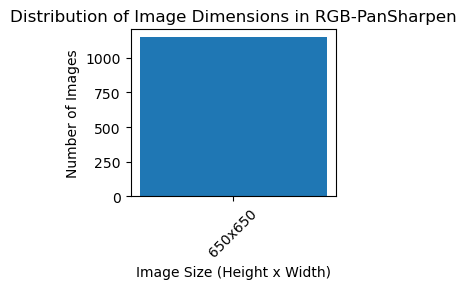

In [11]:
import os
import rasterio
from collections import Counter
import matplotlib.pyplot as plt

# Directory with TIFF files
rgb_dir = "/home/paster/LMY/AOI_3_Paris_Train/RGB-PanSharpen"

# Collect (height, width) for each file
shape_counter = Counter()

for filename in os.listdir(rgb_dir):
    if filename.endswith(".tif"):
        path = os.path.join(rgb_dir, filename)
        try:
            with rasterio.open(path) as src:
                shape = (src.height, src.width)
                shape_counter[shape] += 1
        except Exception as e:
            print(f"Error reading {filename}: {e}")

# Prepare data for plotting
labels = [f"{h}x{w}" for (h, w) in shape_counter.keys()]
counts = list(shape_counter.values())

# Plot
plt.figure(figsize=(3, 3))
plt.bar(labels, counts)
plt.xlabel("Image Size (Height x Width)")
plt.ylabel("Number of Images")
plt.title("Distribution of Image Dimensions in RGB-PanSharpen")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## distribution of tiff image size

100%|██████████| 1148/1148 [00:00<00:00, 304019.51it/s]


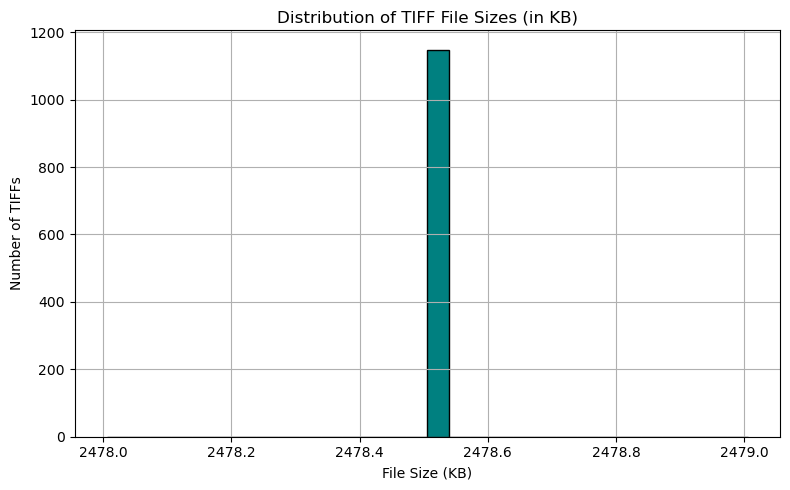

In [6]:
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# Directory with TIFF files
rgb_dir = "/home/paster/LMY/AOI_3_Paris_Train/RGB-PanSharpen"

# Collect file sizes in KB
file_sizes_kb = []

for fname in tqdm(os.listdir(rgb_dir)):
    if fname.endswith(".tif"):
        path = os.path.join(rgb_dir, fname)
        try:
            size_bytes = os.path.getsize(path)
            size_kb = size_bytes / 1024  # convert bytes → KB
            file_sizes_kb.append(size_kb)
        except Exception as e:
            print(f"Failed to access {fname}: {e}")

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(file_sizes_kb, bins=30, color='teal', edgecolor='black')
plt.xlabel("File Size (KB)")
plt.ylabel("Number of TIFFs")
plt.title("Distribution of TIFF File Sizes (in KB)")
plt.grid(True)
plt.tight_layout()
plt.show()




In [7]:
import os
import numpy as np
from tqdm import tqdm

# Directory with TIFFs
rgb_dir = "/home/paster/LMY/AOI_3_Paris_Train/RGB-PanSharpen"

# Gather file sizes in KB
file_sizes_kb = []

for fname in tqdm(os.listdir(rgb_dir)):
    if fname.endswith(".tif"):
        path = os.path.join(rgb_dir, fname)
        try:
            size_bytes = os.path.getsize(path)
            size_kb = size_bytes / 1024
            file_sizes_kb.append(size_kb)
        except Exception as e:
            print(f"Failed to access {fname}: {e}")

# Convert to numpy array for stats
sizes = np.array(file_sizes_kb)

# Print statistics
print(f"TIFF File Size Statistics (in KB):")
print(f"  • Min:     {sizes.min():,.2f} KB")
print(f"  • Max:     {sizes.max():,.2f} KB")
print(f"  • Mean:    {sizes.mean():,.2f} KB")
print(f"  • Median:  {np.median(sizes):,.2f} KB")
print(f"  • Std Dev: {sizes.std():,.2f} KB")


100%|██████████| 1148/1148 [00:00<00:00, 339878.66it/s]

TIFF File Size Statistics (in KB):
  • Min:     2,478.51 KB
  • Max:     2,478.51 KB
  • Mean:    2,478.51 KB
  • Median:  2,478.51 KB
  • Std Dev: 0.00 KB


##  resolutions of a few TIFFs

In [8]:
import rasterio

for fname in os.listdir(rgb_dir)[:5]:
    if fname.endswith(".tif"):
        with rasterio.open(os.path.join(rgb_dir, fname)) as src:
            print(f"{fname}: {src.width}x{src.height}, {src.count} bands, {src.dtypes}")


RGB-PanSharpen_AOI_3_Paris_img1235.tif: 650x650, 3 bands, ('uint16', 'uint16', 'uint16')
RGB-PanSharpen_AOI_3_Paris_img43.tif: 650x650, 3 bands, ('uint16', 'uint16', 'uint16')
RGB-PanSharpen_AOI_3_Paris_img1022.tif: 650x650, 3 bands, ('uint16', 'uint16', 'uint16')
RGB-PanSharpen_AOI_3_Paris_img1010.tif: 650x650, 3 bands, ('uint16', 'uint16', 'uint16')
RGB-PanSharpen_AOI_3_Paris_img848.tif: 650x650, 3 bands, ('uint16', 'uint16', 'uint16')


##  in geogson files  the distribution of masks number

  0%|          | 0/1148 [00:00<?, ?it/s]

100%|██████████| 1148/1148 [00:03<00:00, 312.49it/s]


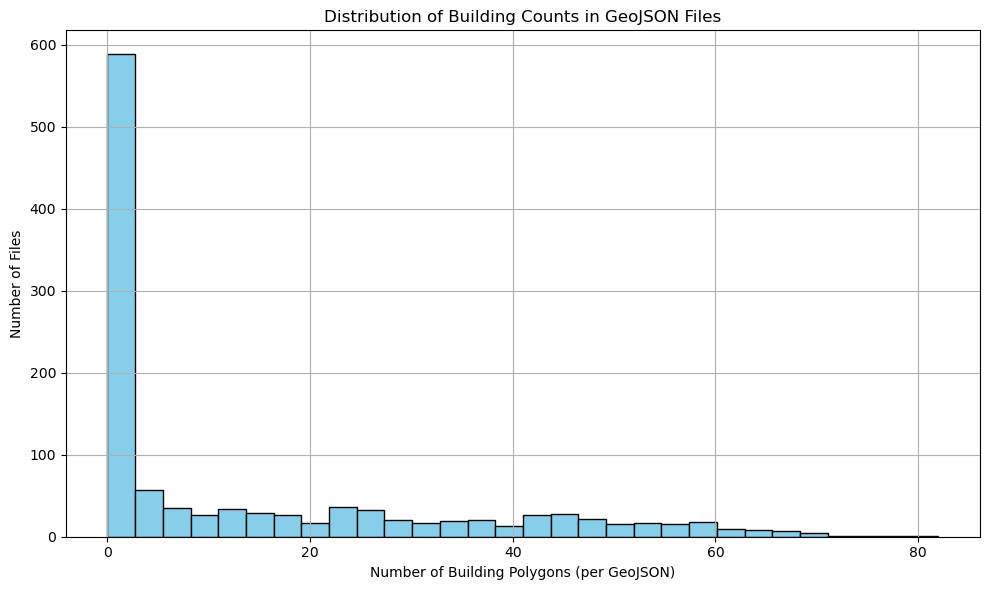

In [13]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Folder with geojson files
geojson_dir = "/home/paster/LMY/AOI_3_Paris_Train/geojson/buildings"

# Collect mask counts
mask_counts = []

for filename in tqdm(os.listdir(geojson_dir)):
    if filename.endswith(".geojson"):
        path = os.path.join(geojson_dir, filename)
        try:
            gdf = gpd.read_file(path)
            mask_counts.append(len(gdf))
        except Exception as e:
            print(f"Failed to read {filename}: {e}")

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(mask_counts, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Number of Building Polygons (per GeoJSON)")
plt.ylabel("Number of Files")
plt.title("Distribution of Building Counts in GeoJSON Files")
plt.grid(True)
plt.tight_layout()
plt.show()


## distribution plot of zero and non zero building count

100%|██████████| 1148/1148 [00:03<00:00, 339.05it/s]


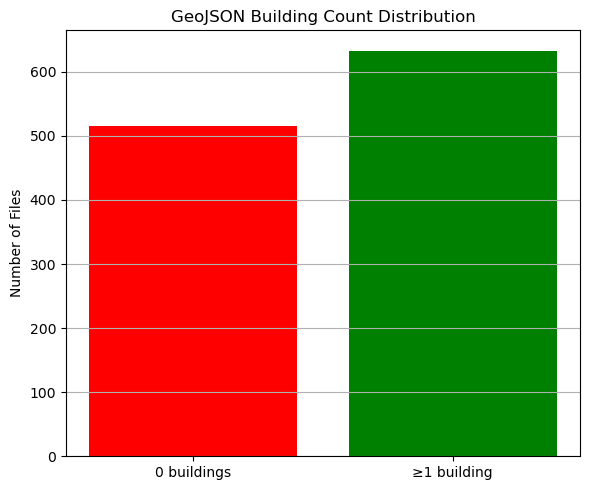

In [1]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Folder with geojson files
geojson_dir = "/home/paster/LMY/AOI_3_Paris_Train/geojson/buildings"

# Counters
zero_count = 0
nonzero_count = 0

# Analyze each file
for filename in tqdm(os.listdir(geojson_dir)):
    if filename.endswith(".geojson"):
        path = os.path.join(geojson_dir, filename)
        try:
            gdf = gpd.read_file(path)
            count = len(gdf)
            if count == 0:
                zero_count += 1
            else:
                nonzero_count += 1
        except Exception as e:
            print(f"Failed to read {filename}: {e}")

# Plot result
plt.figure(figsize=(6, 5))
plt.bar(["0 buildings", "≥1 building"], [zero_count, nonzero_count], color=["red", "green"])
plt.ylabel("Number of Files")
plt.title("GeoJSON Building Count Distribution")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


## distribution of building count zero one and >1

100%|██████████| 1148/1148 [00:05<00:00, 211.61it/s]


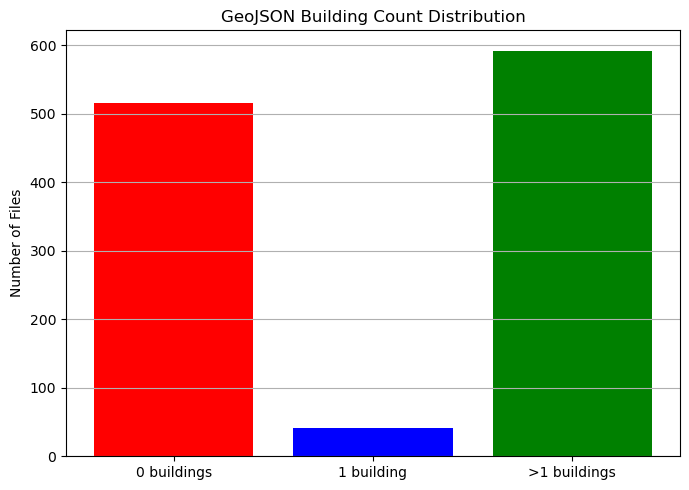

In [2]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Folder with geojson files
geojson_dir = "/home/paster/LMY/AOI_3_Paris_Train/geojson/buildings"

# Initialize counters
count_zero = 0
count_one = 0
count_many = 0

# Analyze files
for filename in tqdm(os.listdir(geojson_dir)):
    if filename.endswith(".geojson"):
        path = os.path.join(geojson_dir, filename)
        try:
            gdf = gpd.read_file(path)
            count = len(gdf)
            if count == 0:
                count_zero += 1
            elif count == 1:
                count_one += 1
            else:
                count_many += 1
        except Exception as e:
            print(f"Failed to read {filename}: {e}")

# Plot bar chart
labels = ["0 buildings", "1 building", ">1 buildings"]
values = [count_zero, count_one, count_many]
colors = ["red", "blue", "green"]

plt.figure(figsize=(7, 5))
plt.bar(labels, values, color=colors)
plt.ylabel("Number of Files")
plt.title("GeoJSON Building Count Distribution")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


~590 images (≈51%) have zero buildings

## These mostly contain empty land, fields, or non-annotated areas

## Keeping all of them would heavily imbalance your dataset

Reason	Benefit
⚖️ Balances classes	=> Prevents model from learning to predict background only

🚀 Faster training	=> Fewer useless samples = faster iteration

💾 Saves disk & RAM	=> Reduces dataset size significantly

🎯 Focused learning	=> Keeps training focused on relevant building patterns


 how many .geojson files have a matching .tif file (same image ID).

In [19]:
import os

# Paths
geojson_dir = "/home/paster/LMY/AOI_3_Paris_Train/geojson/buildings"
tiff_dir = "/home/paster/LMY/AOI_3_Paris_Train/RGB-PanSharpen"

# List GeoJSON image IDs
geojson_ids = set(
    fname.replace("buildings_", "").replace(".geojson", "")
    for fname in os.listdir(geojson_dir)
    if fname.endswith(".geojson")
)

# List TIFF image IDs
tiff_ids = set(
    fname.replace("RGB-PanSharpen_", "").replace(".tif", "")
    for fname in os.listdir(tiff_dir)
    if fname.endswith(".tif")
)

# Find matches
matched_ids = geojson_ids & tiff_ids

print(f"Total GeoJSON files: {len(geojson_ids)}")
print(f"Total TIFF files: {len(tiff_ids)}")
print(f"Matching image IDs: {len(matched_ids)}")


Total GeoJSON files: 1148
Total TIFF files: 1148
Matching image IDs: 1148


## confirm the range of building counts

In [20]:
import os
import geopandas as gpd

geojson_dir = "/home/paster/LMY/AOI_3_Paris_Train/geojson/buildings"

building_counts = []

for fname in os.listdir(geojson_dir):
    if fname.endswith(".geojson"):
        path = os.path.join(geojson_dir, fname)
        try:
            gdf = gpd.read_file(path)
            building_counts.append(len(gdf))
        except Exception as e:
            print(f"Error reading {fname}: {e}")

print(f"Total files: {len(building_counts)}")
print(f"Min buildings: {min(building_counts)}")
print(f"Max buildings: {max(building_counts)}")
print(f"Unique counts: {sorted(set(building_counts))[:20]} ...")


Total files: 1148
Min buildings: 0
Max buildings: 82
Unique counts: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] ...


## visualize tiff images for different distributions samples

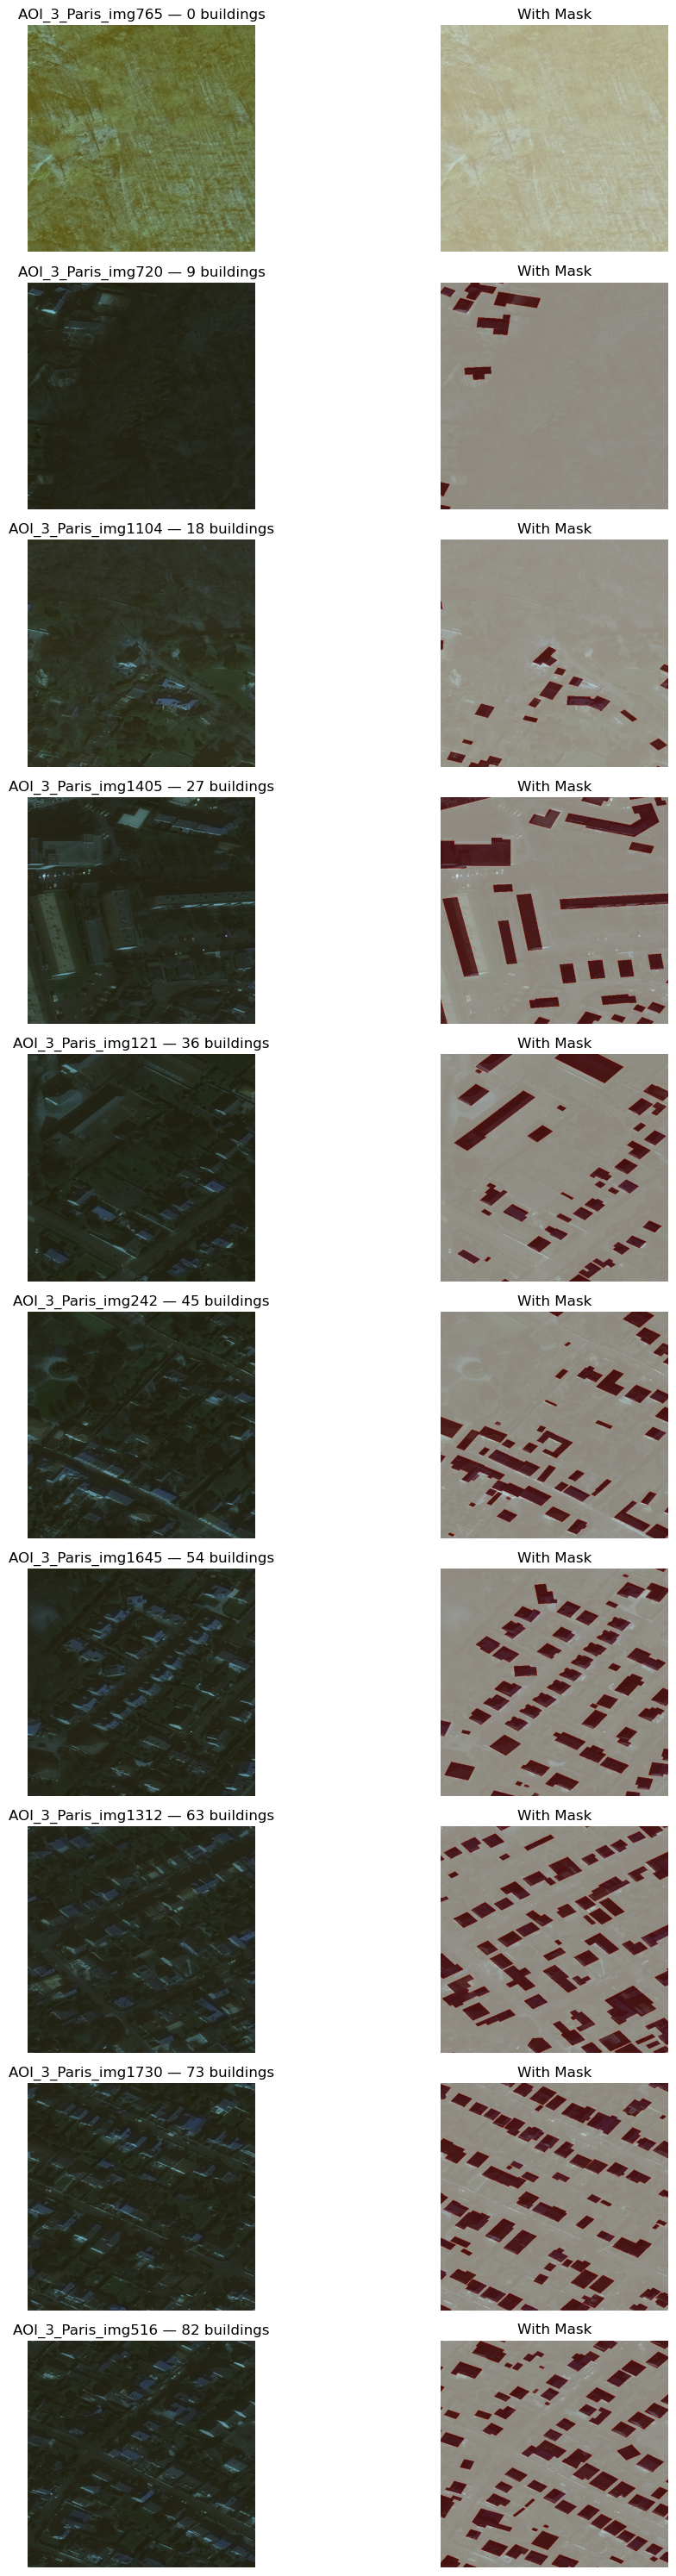

In [23]:
import os
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_image
from rasterio.features import rasterize
import numpy as np

# Directories
geojson_dir = "/home/paster/LMY/AOI_3_Paris_Train/geojson/buildings"
tiff_dir = "/home/paster/LMY/AOI_3_Paris_Train/RGB-PanSharpen"

# Step 1: Collect valid (count, image_id) pairs
all_entries = []

for fname in os.listdir(geojson_dir):
    if not fname.endswith(".geojson"):
        continue

    img_id = fname.replace("buildings_", "").replace(".geojson", "")
    tif_path = os.path.join(tiff_dir, f"RGB-PanSharpen_{img_id}.tif")
    if not os.path.exists(tif_path):
        continue

    try:
        gdf = gpd.read_file(os.path.join(geojson_dir, fname))
        count = len(gdf)
        all_entries.append((count, img_id))
    except:
        continue

# Step 2: Define 10 target building counts spread evenly
all_entries = sorted(all_entries, key=lambda x: x[0])
counts = [e[0] for e in all_entries]
min_count, max_count = min(counts), max(counts)
target_counts = np.linspace(min_count, max_count, 10, dtype=int)

# Step 3: Find closest match to each target
sampled = []
used_ids = set()

for target in target_counts:
    closest = min(
        (entry for entry in all_entries if entry[1] not in used_ids),
        key=lambda x: abs(x[0] - target),
        default=None
    )
    if closest:
        sampled.append(closest)
        used_ids.add(closest[1])

# Step 4: Plot — 10 rows × 2 columns (original + mask)
fig, axs = plt.subplots(len(sampled), 2, figsize=(12, 3 * len(sampled)))

for row_idx, (count, img_id) in enumerate(sampled):
    tif_path = os.path.join(tiff_dir, f"RGB-PanSharpen_{img_id}.tif")
    geojson_path = os.path.join(geojson_dir, f"buildings_{img_id}.geojson")

    try:
        with rasterio.open(tif_path) as src:
            img = src.read([3, 2, 1])  # RGB bands
            img = reshape_as_image(img)
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)
            transform = src.transform
            shape = src.shape

        # Rasterize mask
        gdf = gpd.read_file(geojson_path).to_crs(src.crs)
        mask = rasterize(
            [(geom, 1) for geom in gdf.geometry],
            out_shape=shape,
            transform=transform,
            fill=0
        )

        # Left: original RGB
        axs[row_idx, 0].imshow(img)
        axs[row_idx, 0].set_title(f"{img_id} — {count} buildings")
        axs[row_idx, 0].axis("off")

        # Right: RGB + mask
        axs[row_idx, 1].imshow(img)
        axs[row_idx, 1].imshow(mask, cmap='Reds', alpha=0.5)
        axs[row_idx, 1].set_title("With Mask")
        axs[row_idx, 1].axis("off")

    except Exception as e:
        axs[row_idx, 0].set_title(f"{img_id} — Error")
        axs[row_idx, 1].set_title("Error")
        axs[row_idx, 0].axis("off")
        axs[row_idx, 1].axis("off")
        print(f"Error processing {img_id}: {e}")

plt.tight_layout()
plt.show()


## mask size distribution plot 

100%|██████████| 1148/1148 [00:07<00:00, 148.07it/s]


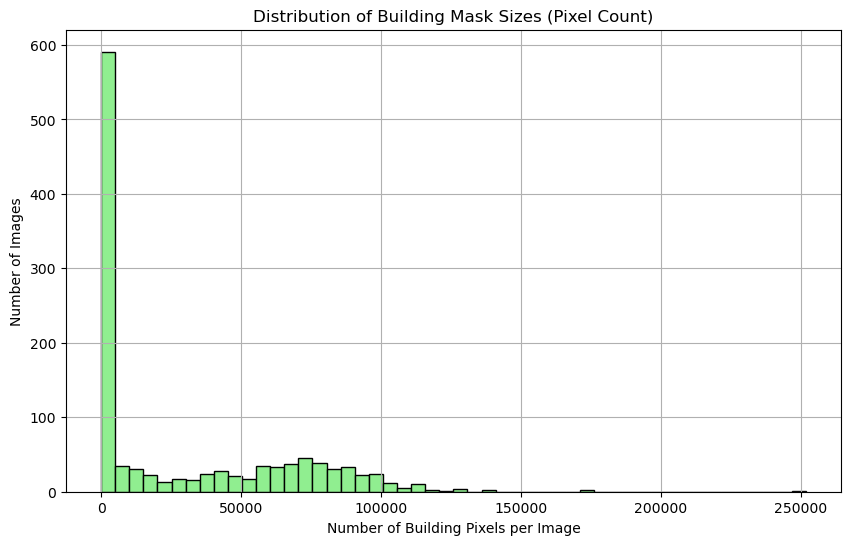

In [24]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.features import rasterize
from tqdm import tqdm

# Paths
geojson_dir = "/home/paster/LMY/AOI_3_Paris_Train/geojson/buildings"
tiff_dir = "/home/paster/LMY/AOI_3_Paris_Train/RGB-PanSharpen"

# Collect mask pixel counts
mask_pixels = []

for fname in tqdm(os.listdir(geojson_dir)):
    if not fname.endswith(".geojson"):
        continue

    img_id = fname.replace("buildings_", "").replace(".geojson", "")
    tif_path = os.path.join(tiff_dir, f"RGB-PanSharpen_{img_id}.tif")
    geojson_path = os.path.join(geojson_dir, fname)

    if not os.path.exists(tif_path):
        continue

    try:
        with rasterio.open(tif_path) as src:
            shape = src.shape
            transform = src.transform

        gdf = gpd.read_file(geojson_path)
        mask = rasterize(
            [(geom, 1) for geom in gdf.geometry],
            out_shape=shape,
            transform=transform,
            fill=0
        )

        building_area = mask.sum()  # total building pixels
        mask_pixels.append(building_area)

    except Exception as e:
        print(f"Skipping {fname}: {e}")

# Plot
plt.figure(figsize=(10, 6))
plt.hist(mask_pixels, bins=50, color='lightgreen', edgecolor='black')
plt.title("Distribution of Building Mask Sizes (Pixel Count)")
plt.xlabel("Number of Building Pixels per Image")
plt.ylabel("Number of Images")
plt.grid(True)
plt.show()


##  sample and visualize TIFF+mask pairs from different points in the mask size distribution (from smallest to largest total building area).

✅ Retained 633 valid image/mask pairs with >0 building pixels


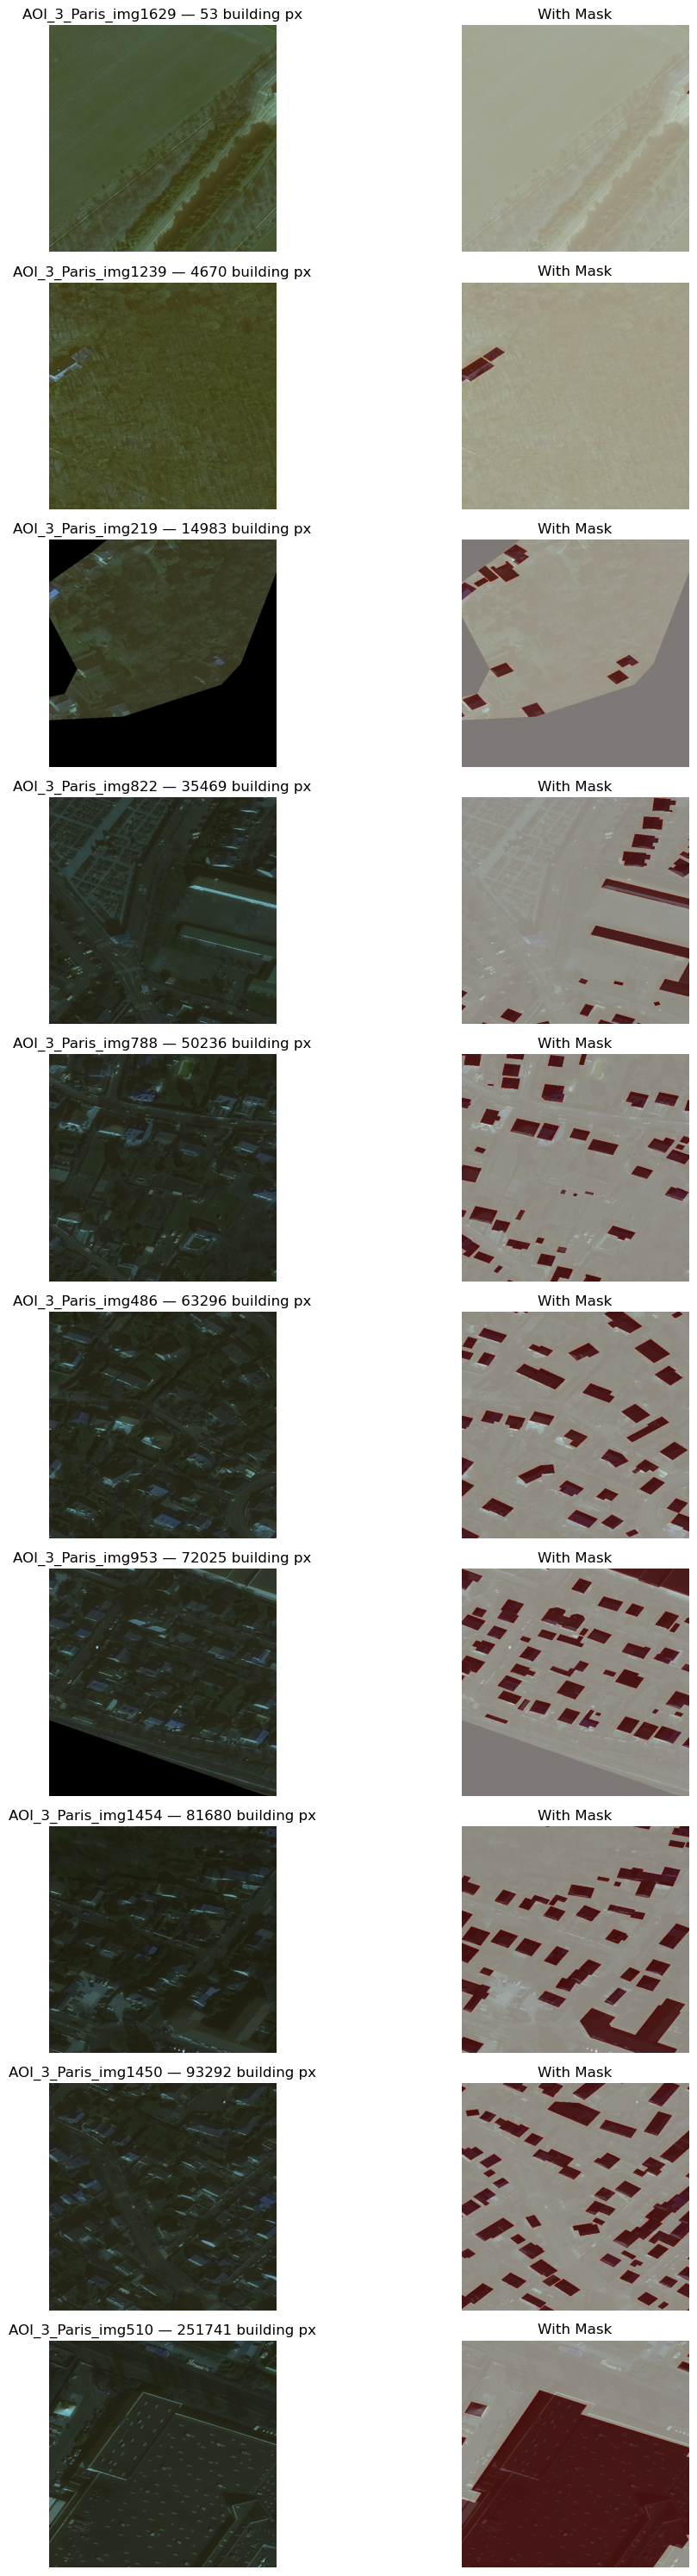

In [26]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import reshape_as_image
from rasterio.features import rasterize
import numpy as np

# Paths
geojson_dir = "/home/paster/LMY/AOI_3_Paris_Train/geojson/buildings"
tiff_dir = "/home/paster/LMY/AOI_3_Paris_Train/RGB-PanSharpen"

# Step 1: Collect valid (mask_pixel_count, image_id) pairs
mask_data = []

for fname in os.listdir(geojson_dir):
    if not fname.endswith(".geojson"):
        continue

    img_id = fname.replace("buildings_", "").replace(".geojson", "")
    tif_path = os.path.join(tiff_dir, f"RGB-PanSharpen_{img_id}.tif")
    geojson_path = os.path.join(geojson_dir, fname)

    if not os.path.exists(tif_path):
        continue

    try:
        with rasterio.open(tif_path) as src:
            shape = src.shape
            transform = src.transform

        gdf = gpd.read_file(geojson_path)

        # Rasterize mask
        mask = rasterize(
            [(geom, 1) for geom in gdf.geometry if geom.is_valid],
            out_shape=shape,
            transform=transform,
            fill=0
        )

        total_mask_pixels = mask.sum()
        if total_mask_pixels > 0:
            mask_data.append((total_mask_pixels, img_id))

    except Exception as e:
        print(f"Skipping {img_id}: {e}")

print(f"✅ Retained {len(mask_data)} valid image/mask pairs with >0 building pixels")

# Step 2: Sample 10 examples from min to max
mask_data.sort()
sample_indices = np.linspace(0, len(mask_data) - 1, 10, dtype=int)
sampled = [mask_data[i] for i in sample_indices]

# Step 3: Plot
fig, axs = plt.subplots(len(sampled), 2, figsize=(12, 3 * len(sampled)))

for row_idx, (pixel_count, img_id) in enumerate(sampled):
    tif_path = os.path.join(tiff_dir, f"RGB-PanSharpen_{img_id}.tif")
    geojson_path = os.path.join(geojson_dir, f"buildings_{img_id}.geojson")

    try:
        with rasterio.open(tif_path) as src:
            img = src.read([3, 2, 1])  # RGB
            img = reshape_as_image(img)
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)
            transform = src.transform
            shape = src.shape

        gdf = gpd.read_file(geojson_path).to_crs(src.crs)
        mask = rasterize(
            [(geom, 1) for geom in gdf.geometry if geom.is_valid],
            out_shape=shape,
            transform=transform,
            fill=0
        )

        # RGB image
        axs[row_idx, 0].imshow(img)
        axs[row_idx, 0].set_title(f"{img_id} — {int(pixel_count)} building px")
        axs[row_idx, 0].axis("off")

        # RGB + mask
        axs[row_idx, 1].imshow(img)
        axs[row_idx, 1].imshow(mask, cmap='Reds', alpha=0.5)
        axs[row_idx, 1].set_title("With Mask")
        axs[row_idx, 1].axis("off")

    except Exception as e:
        axs[row_idx, 0].set_title("Error")
        axs[row_idx, 1].set_title("Error")
        axs[row_idx, 0].axis("off")
        axs[row_idx, 1].axis("off")
        print(f"Error rendering {img_id}: {e}")

plt.tight_layout()
plt.show()


##  building mask for that image contains only 53 pixels with value 1 => all masks (cumulative)

##  distribution plot of minimal amd maximal area mask per image

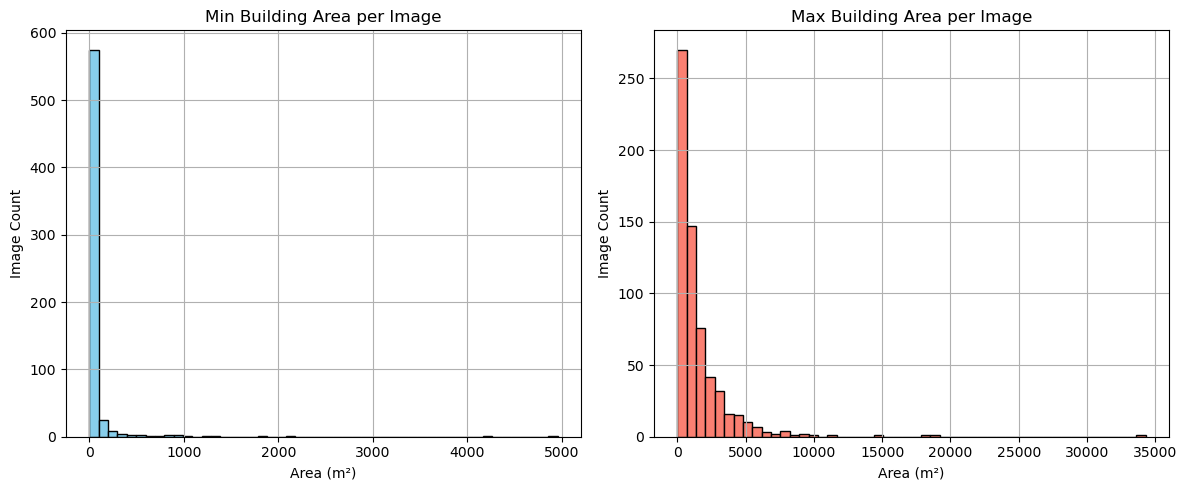

In [ ]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt

geojson_dir = "/home/paster/LMY/AOI_3_Paris_Train/geojson/buildings"
tiff_dir = "/home/paster/LMY/AOI_3_Paris_Train/RGB-PanSharpen"

min_areas = []
max_areas = []

for fname in os.listdir(geojson_dir):
    if not fname.endswith(".geojson"):
        continue

    try:
        gdf = gpd.read_file(os.path.join(geojson_dir, fname))
        gdf = gdf[gdf.geometry.notnull() & gdf.geometry.is_valid]

        if len(gdf) == 0:
            continue

        # Project to metric CRS for accurate area (meters²)
        gdf = gdf.to_crs(epsg=3857)

        areas = gdf.geometry.area
        min_areas.append(areas.min())
        max_areas.append(areas.max())

    except Exception as e:
        print(f"Skipping {fname}: {e}")

# Plot histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(min_areas, bins=50, color="skyblue", edgecolor="black")
plt.title("Min Building Area per Image")
plt.xlabel("Area (m²)")
plt.ylabel("Image Count")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(max_areas, bins=50, color="salmon", edgecolor="black")
plt.title("Max Building Area per Image")
plt.xlabel("Area (m²)")
plt.ylabel("Image Count")
plt.grid(True)

plt.tight_layout()
plt.show()


##  for max => visualize 5 tiffs with and without mask

In [36]:
import os
print(os.listdir("/home/paster/LMY/AOI_3_Paris_Train/geojson"))


['buildings']


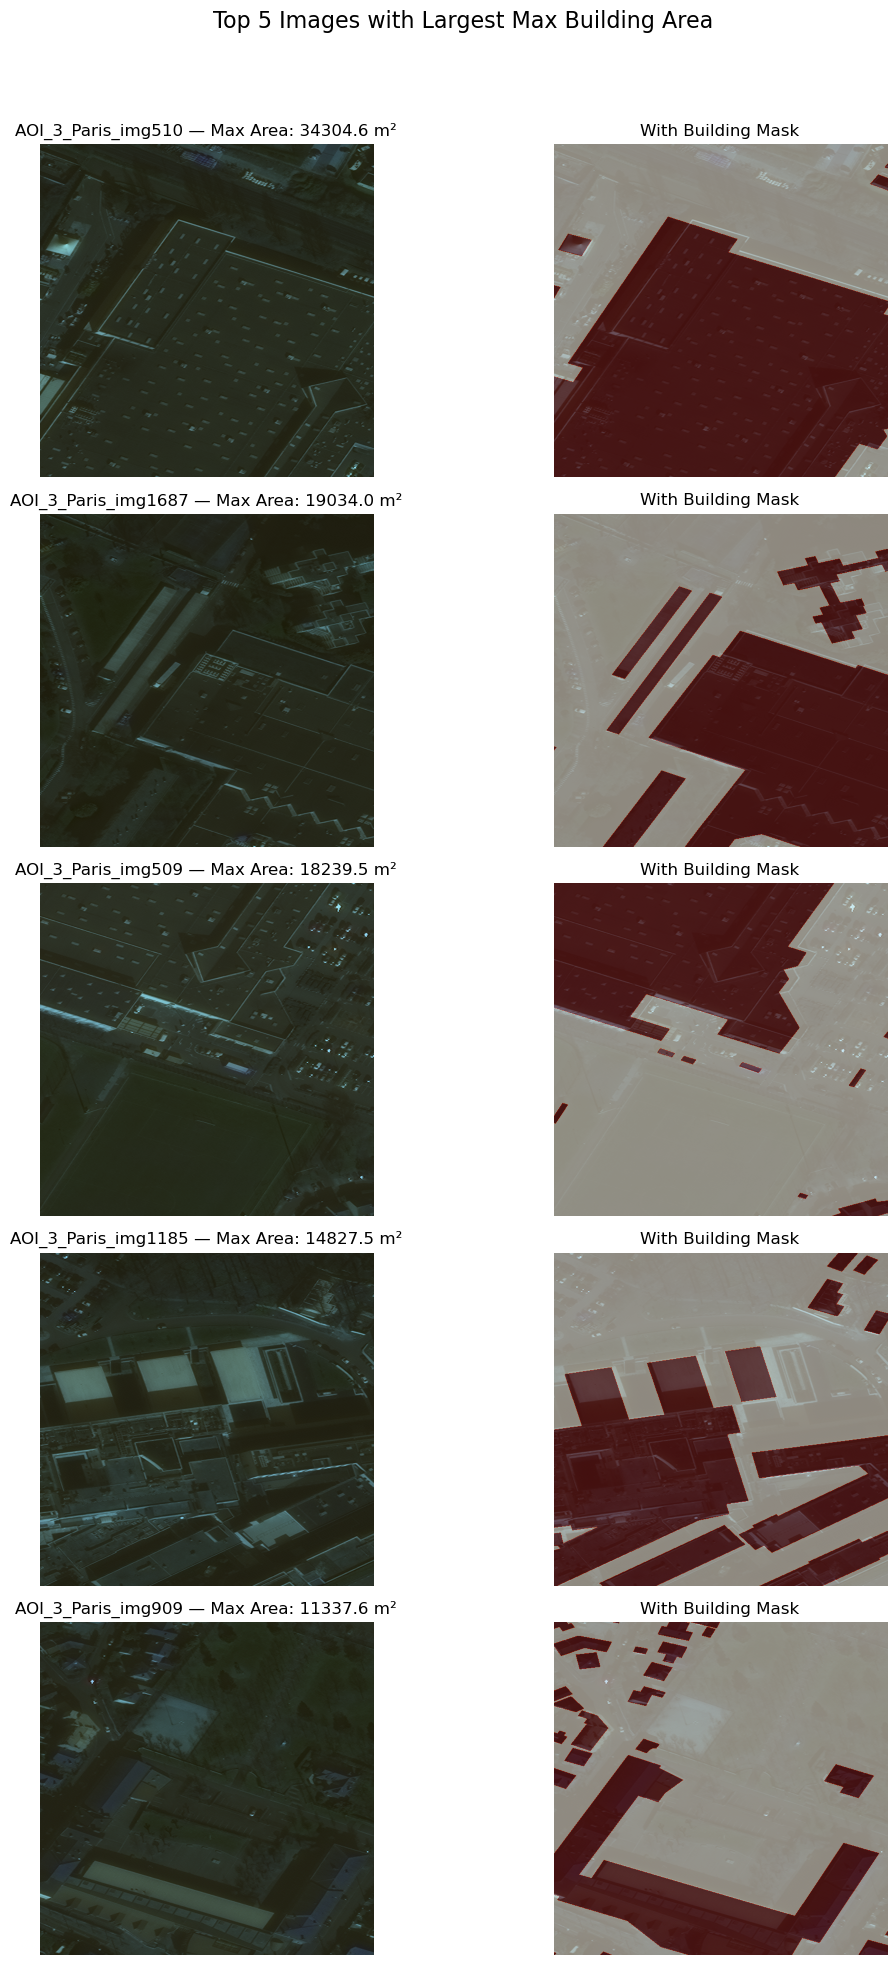

In [40]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import reshape_as_image
from rasterio.features import rasterize
import numpy as np

geojson_dir = "/home/paster/LMY/AOI_3_Paris_Train/geojson/buildings"
tiff_dir = "/home/paster/LMY/AOI_3_Paris_Train/RGB-PanSharpen"

image_stats = []

# Step 1: Collect max building area for each image
for fname in os.listdir(geojson_dir):
    if not fname.endswith(".geojson"):
        continue

    img_id = fname.replace("buildings_", "").replace(".geojson", "")
    geojson_path = os.path.join(geojson_dir, fname)
    tiff_path = os.path.join(tiff_dir, f"RGB-PanSharpen_{img_id}.tif")

    if not os.path.exists(tiff_path):
        continue

    try:
        gdf = gpd.read_file(geojson_path)
        gdf = gdf[gdf.geometry.notnull() & gdf.geometry.is_valid]
        if len(gdf) == 0:
            continue

        gdf = gdf.to_crs(epsg=3857)
        gdf["area"] = gdf.geometry.area
        gdf = gdf[gdf["area"] > 0]
        if len(gdf) == 0:
            continue

        max_area = gdf["area"].max()
        image_stats.append((max_area, img_id))

    except Exception as e:
        print(f"Skipping {fname}: {e}")

# Step 2: Select top 5 images with largest max building area
top_samples = sorted(image_stats, key=lambda x: x[0], reverse=True)[:5]

# Step 3: Visualization
fig, axs = plt.subplots(len(top_samples), 2, figsize=(12, len(top_samples)*4))
fig.suptitle("Top 5 Images with Largest Max Building Area", fontsize=16)

for idx, (max_area, img_id) in enumerate(top_samples):
    geojson_path = os.path.join(geojson_dir, f"buildings_{img_id}.geojson")
    tiff_path = os.path.join(tiff_dir, f"RGB-PanSharpen_{img_id}.tif")

    try:
        with rasterio.open(tiff_path) as src:
            img = src.read([3, 2, 1])
            img = reshape_as_image(img)
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)
            transform = src.transform
            shape = src.shape

        gdf = gpd.read_file(geojson_path).to_crs(src.crs)
        geometries = [(geom, 1) for geom in gdf.geometry if geom.is_valid]

        mask = rasterize(
            geometries,
            out_shape=shape,
            transform=transform,
            fill=0
        )

        axs[idx, 0].imshow(img)
        axs[idx, 0].set_title(f"{img_id} — Max Area: {max_area:.1f} m²")
        axs[idx, 0].axis("off")

        axs[idx, 1].imshow(img)
        axs[idx, 1].imshow(mask, cmap="Reds", alpha=0.5)
        axs[idx, 1].set_title("With Building Mask")
        axs[idx, 1].axis("off")

    except Exception as e:
        print(f"Error with {img_id}: {e}")
        axs[idx, 0].set_title("Error")
        axs[idx, 1].set_title("Error")
        axs[idx, 0].axis("off")
        axs[idx, 1].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
